In [98]:
import numpy as np
import math
from sklearn.metrics import accuracy_score 
from tqdm import tqdm

In [99]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [100]:
cifar_dataset = r'/Users/adityadandwate/Desktop/Projects/Proper/cifar-10/cifar-10-batches-py'


In [101]:
types = ['batches.meta', 'data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5', 'test_batch']
set_data = [0,1,2,3,4,5,6]

for i, y in zip(set_data, types):
    set_data[i] = unpickle(cifar_dataset + '/' +y)

print(type(set_data))

<class 'list'>


In [102]:
# data_dict = {}

# for i in range(7):
#     data_dict[types[i]] = set_data[i]

# print(type(data_dict))
# print(data_dict['batches.meta'])

#Alternate way
batch_meta = set_data[0]
data_batch1 = set_data[1]
data_batch2 = set_data[2]
data_batch3 = set_data[3]
data_batch4 = set_data[4]
data_batch5 = set_data[5]
test_batch = set_data[6]



In [103]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


In [104]:
#testing reshaping

X = data_batch1[b'data']
print(X.shape)

#reshaping X and then transposing
X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
X.shape


(10000, 3072)


(10000, 32, 32, 3)

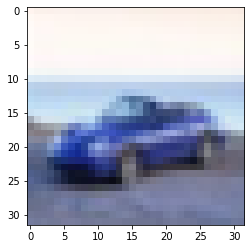

In [105]:
#Testing plt 
plt.imshow(X[524])

In [106]:
#One hot encoding function=

def one_hot(vec, vals = 10):
    n = len(vec)
    out = np.zeros((n,vals))
    out[range(n), vec] = 1
    return out

In [107]:
class CifarClass():    #Creating the class for the relevant methods

    def __init__(self, learning_rate = 0.1, max_iter = 1000, minimum_step_size = 0.001, early_stopping = True, n=20):
        self.i = 0
        self.training_sets = [data_batch1, data_batch2, data_batch3, data_batch4, data_batch5]
        self.test_set = [test_batch]
        self.training_images = None
        self.training_labels = None 
        self.testing_images = None
        self.testing_labels = None
        self.__learning_rate = learning_rate
        self.__max_iter = max_iter
        self.__minimum_step_size = minimum_step_size
        self.__early_stopping = early_stopping
        self.__n = n


    def setup_of_images(self):
        self.training_images = np.vstack([j[b"data"] for j in self.training_sets]) #Concatenating all training images from all batches
        train_len = len(self.training_images)
        self.training_images = self.training_images.reshape(train_len, 3, 32, 32).transpose(0,2,3,1)/255 #reshaping
        self.training_labels = one_hot(np.hstack([j[b'labels'] for j in self.training_sets]), 10) #one hot encodig of the labels

        self.testing_images = np.vstack([j[b'data'] for j in self.test_set])
        test_len = len(self.testing_images)
        self.testing_images = self.testing_images.reshape(test_len, 3 ,32 ,32).transpose(0,2,3,1)/255 #reshaping 
        self.testing_labels = one_hot(np.hstack([j[b'labels'] for j in self.test_set]), 10)

    def next_batch(self, batch_size):
        x = self.training_images[self.i: self.i + batch_size].reshape(100, 32, 32, 3)
        y = self.training_labels[self.i: self.i + batch_size]
        self.i = (self.i + batch_size)%len(self.training_images)
        return x,y

    #calculating the score for x for a given class k
    def __calculate_score(self, k, x):
        weight = self.__weights[k]
        return np.exp(x.dot(weight))

    def __calculate_softmax(self, k, x):
        summation = 0
        for i in range(self.__class_count):
            summation += self.__calculate_score(i,x)
            
        return self.__calculate_score(k,x)/summation

    def __cross_entropy_gradient(self, k):
        sum = 0
        for i in range (len(self.__x)):
            sum += ((self.__calculate_softmax(k,self.__x[i]) - self.__y[i][k]) * self.__x[i])
        return sum / len(self.__x)
    
    def __new_weights(self, k): 
        #no change if class is in exclusion list
        if k in self.__exclusion_list:
            return self.__weights[k]

        step_size = self.__cross_entropy_gradient(k)*self.__learning_rate

        #code to add classes to excleusion list
        if np.amax(step_size) <= self.__minimum_step_size:
            self.__exclusion_list.append(k)
        
        return self.__weights[k] - step_size
    
    def train(self, X, y):
        
        if self.__early_stopping:
            split_index = int(len(X) * 0.1)
            self.__x = X[split_index:]
            self.__y = y[split_index:]
            self.__x_val = X[:split_index]
            self.__y_val = y[:split_index]
        else:
            self.__x = X
            self.__y = y 

        self.__class_count = len(self.__y[0])
        self.__weights = np.random.rand(self.__class_count, X.shape[1])
        self.__exclusion_list = []
        max_acc = -1
        n=0
        
        for i in tqdm(range(self.__max_iter)):
            for j in tqdm(range(self.__class_count)):
                self.__weights[j] = self.__new_weights(j)
            
            #stop training once all classes have been added to the exclusion list
            if len(self.__exclusion_list) == self.__class_count:
                break
            
            #if early stopping is enabled
            if (self.__early_stopping):
                y_val_pred = self.predict(self.__x_val)
                acc = accuracy_score(self.__y_val, y_val_pred)
                if acc == max_acc:
                    max_acc = acc
                    n = 0
                else:
                    n += 1
                    if n >= self.__n:
                        break
    
    #returns the prediccted label in one hot encoded form
    def predict(self, X):
        y= np.zeros((len(X), self.__class_count))
        for i in range(len(X)):
            max_score_idx = 0
            max_score = 0
            for j in range(self.__class_count):
                score = self.__calculate_softmax(j, X[i])
                if score > max_score:
                    max_score = score
                    max_score_idx = j
            y[i][max_score_idx] = 1
        return y


In [108]:
cc = CifarClass() 
cc.setup_of_images()

print (cc.training_images.shape)
print(cc.testing_images.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [109]:
#reflattening lol

cc.training_images = cc.training_images.reshape(50000, 3072)
print(cc.training_images.shape)
cc.testing_images = cc.testing_images.reshape(10000, 3072)
print(cc.testing_images.shape)

(50000, 3072)
(10000, 3072)


In [110]:
def main():
   
    X_train = cc.training_images
    y_train = cc.training_labels

    X_test = cc.testing_images
    y_test = cc.testing_labels

    cc.train(X_train, y_train)

    predictions = cc.predict(X_test)

    print(accuracy_score(y_test, predictions))

In [111]:
if __name__ == "__main__":
    main()

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/adityadandwate/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in exp
/Users/adityadandwate/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
/Users/adityadandwate/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in double_scalars
  2%|▏         | 19/1000 [07:41<6:37:32, 24.31s/it]


0.1
